Welcome to your assignment this week! 

To better understand explainable AI, in this assignment, we will look at the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way. We use a real-world dataset on Census income, also known as the __[*Adult dataset*](https://archive.ics.uci.edu/ml/datasets/Adult)__ available in the *UCI* ML Repository where we will predict if the potential income of people is more than $50K/year or not.

For this assignment, we will use: 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
- [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) which is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements. Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.




__[LIME GitHub](https://github.com/marcotcr/lime)__


**After this assignment you will be able to:** use the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way.


Let's get started! Run the following cell to install all the packages you will need.


In [1]:
!pip install numpy
!pip install matplotlib
!pip install lime
!pip install shap
!pip install sklearn
!pip install xgboost
!pip install graphviz
!pip install pydot
!pip install pydotplus
!pip install seaborn


Run the following cell to load the packages you will need.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import itertools

##
from utils import *
##

from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import graphviz
from io import StringIO
from sklearn import datasets,tree
import pydot
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image


import warnings
warnings.filterwarnings('ignore')
#plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

Next, let's load the census dataset. Run the following cell to load the features `X` and the labels `y`. 

In [3]:
X_raw, y = shap.datasets.adult(display=True)

X_raw = X_raw.drop(columns=['Capital Gain']) # These two features are intentionally removed.
X_raw = X_raw.drop(columns=['Capital Loss']) # These two features are intentionally removed.

labels = np.array([int(label) for label in y])

print('The shape of X_raw is: ',X_raw.shape)
print('The shape of y is: ',labels.shape)

The shape of X_raw is:  (32561, 10)
The shape of y is:  (32561,)


You've loaded:

- `X_raw`: a DataFrame containing 32,561 instances with 12 features.
- `y`: the list of binary labels for the 32,561 examples. If salary of instance $i$ is more than \\$50K: $y^{(i)} = 1$ otherwise: $y^{(i)} = 0$.


# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


|Num| Attribute Name | Type | Description |
|----|----------------------------------------------------------|------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|1| Age | Continuous | Represents age of the person <br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked)|
|2| Workclass | Categorical | Represents the workclass of the person. <br> (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,<br> Local-gov, State-gov, Without-pay, Never-worked). |
|3| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
|4| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
|5| Occupation | Categorical | Represents the type of profession job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
|6| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
|7| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
|8| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
|9| Capital Gain | Continuous | The total capital gain for the person |
|10| Capital Loss | Continuous | The total capital loss for the person |
|11| Hours per week | Continuous | Total hours spent working per week |
|12| Country | Categorical | The country where the person was born |
|13| Income Label  | Categorical | The class label column is the one we want to predict |     



We have a total of 12 features and our objective is to predict if the income of a person will be more than $\$50$K  (True) or less than $\$50$K (False). Hence we will be building and interpreting a classification model. 

Let's have a look at the first three instances of the dataset (you can use `X.head(3)` to see the content of the dataset):


![](images/dataset.png)


For example, the first person is 39 years old, works for the state governement, is a Male and was born in the US. By using `y[0:3]` you can get  binary values indicating whether these persons have an income higher than $\$50$K or no.

# Pre-processing
Converting the categorical columns with string values to numeric representations. Typically the XGBoost model can handle categorical data natively being a tree-based model so we don't one-hot encode the features

In [4]:
mapping = {}
cat_cols = X_raw.select_dtypes(['category']).columns
for col in cat_cols:
    mapping[col] = dict( enumerate(X_raw[col].cat.categories ) )
indices_cat_cols = [ list(X_raw.columns).index(x) for x in cat_cols ]
X = X_raw.copy()
X[cat_cols] = X_raw[cat_cols].apply(lambda x: x.cat.codes)
headers=list(X.columns)
X.head(3)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,40.0,39
1,50.0,6,13.0,2,4,0,4,1,13.0,39
2,38.0,4,9.0,0,6,1,4,1,40.0,39


Let's have a look at the distribution of people with <=  $\$50$K (0) and > $\$50$K (1) income:

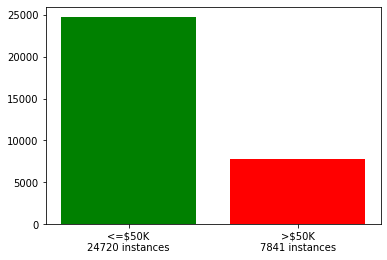

In [5]:
plt.bar([0], height=[Counter(labels)[0]], color="green")
plt.bar([1], height=[Counter(labels)[1]], color="red")
plt.xticks([0, 1], ['<=$50K\n'+str(Counter(labels)[0])+' instances',
                    '>$50K\n'+str(Counter(labels)[1])+' instances'])
plt.show()

# Split Train and Test Datasets

As in any Machine Learning, we need to partition the dataset into two subsets -- a training and testset. Please note that in practice, the dataset needs to be partitioned into three subsets, the third once being the validation set which will be used for hyperparameters tuning. However, in this assignment, we will not tune the hyperparameters.

Run the following to split the dataset accordingly:


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=y)
print('The shape of training set is: ',X_train.shape)
print('The shape of test set is: ',X_test.shape)


The shape of training set is:  (22792, 10)
The shape of test set is:  (9769, 10)


You've created:

- `X_train`: a trainig DataFrame containing 22,792 instances used for training.
- `y_train`: the list of binary labels for the 22,792 instances of the training set.
- `X_test`: a test DataFrame containing 9,769 instances used for  testing.
- `y_test`: the list of binary labels for the 9,769 instances of the test set.

We note that since we are using a stratified splitting, the distribution of samples in the training and test set is similar to the distribution in the dataset, i.e., roughly 24% of positive examples in each subset.

## Training the classification model

Now we train and build a boosting classification model on our training data using [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

Run the following to start the training of the classifier:

In [7]:
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

# Predictions on the test data

Now that the classifier is trained, let's make few predictions on the test set:

In [8]:
predictions = xgc.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


As you can see, our classier is making only 2 errors!

# Model Performance 
 Let's now evaluate the performance of our classifier on the test set. For that, we will call `sklearn.metrics.classification_report()` which returns a text report showing the main classification metrics including: Presicion, Recall, and F1-Score. The reported averages include macro average (averaging the unweighted mean per label) and weighted average (averaging the support-weighted mean per label). 




 

In [9]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      7417
           1       0.67      0.60      0.64      2352

    accuracy                           0.83      9769
   macro avg       0.78      0.76      0.76      9769
weighted avg       0.83      0.83      0.83      9769



To get more details, let's print the confusion matrix:

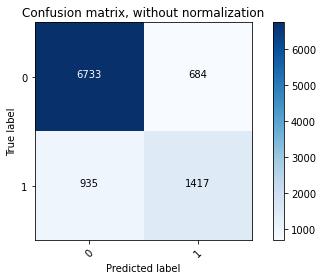

In [10]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')




***

**Task 1**: Please provide comments on the performance of the classifier.

***

I would generally say that the performance of a classifier, and the performance of the confusion matrix, depends on the context of the situation and the purpose of the model. I.E. the tolerance for false negatives might be low when screening for diseases, but it might be higher when designing a marketing campaign.

With this confusion matrix, we can see that the performance with classifying label 1 is worse than it is for classifying label 0. I suspect that this is caused by the imbalanced classes.

If we consider the label 0 to be the 'positive' then we have a TP of 6733, which compared to the FP of 935 and the FN of 684 might seem reasonable. Comparing the TN score of 1417 to the FP and FN makes it seem that predictions of the label being 1 can't really be trusted - although again, this depends on the purpose of the model and whether it can tolerate such weak performances.


# Feature importance:

The global feature importance calcuations that come with XGBoost, enables us to view feature importances based on the following:

- **Feature Weights**: This is based on the number of times a feature appears in a tree across the ensemble of trees.
- **Gain**: This is based on the average gain of splits which use the feature.
- **Coverage**: This is based on the average coverage (number of samples affected) of splits which use the feature.

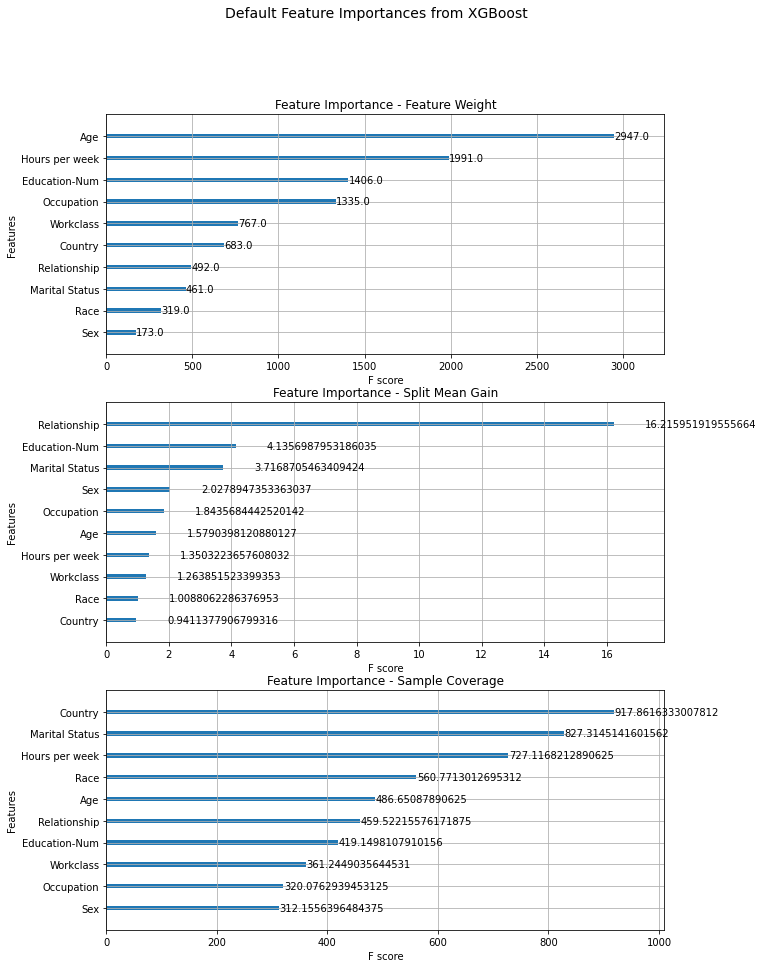

In [11]:
fig = plt.figure(figsize = (10, 15))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(3,1, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t = ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(3,1, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t = ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(3,1, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t = ax3.set_title("Feature Importance - Sample Coverage")

***

**Task 2**: Please provide comments on the above global feature importance calcuations.

***

The Feature Weight chart shows Age as being the most important feature, followed by Hours per week, Education-Num and Occupation respectively. Marital Status, Race and Sex are at the bottom of the chart.
However, this result should be considered carefully. The Feature Weight metric shows how often a feature appears in the trees of a model, but this means that it can over-represent features that are able to be split more often. The feature 'Sex' for example, can only be split into two categories (according to most commonly used datasets, although this can also be represented in different ways). If it is only able to be split into two divisions, then it is limited in how often it can appear in branches of a tree.
The top scoring features on this chart are all much more divisible than the lowest scoring features.

The Split Mean Gain chart shows Relationship as being the most important feature, followed by Education-Num, Marital Status and Sex. The worst performers are Workclass, Race and Country. Relationship is by far the most important feature according to this metric, scoring almost 4 times higher than the next most important feature, and scoring almost as high as all of the other features combined.
Interestingly, Education-Num is the only feature to score in the top three of both this metric and the previous Feature Weight metric.
This metric shows the improvement in acccuracy that splits using this feature provides. This is a very important feature to consider.

The Sample Coverage chart shows Country as being the most important feature, followed by Marital Status, Hours per week and Race. The lowest scoring features are Workclass, Occupation and Sex.
There are no features which appear in the top 4 scores for all metrics, and there are none which appear in the bottom 3 scores for all metrics either.
This metric indicates the number of observations that this feature is related to.

From these three charts we see little agreement in what features are important. With more knowledge of the data, and with an idea of what the purpose of our model is, these charts could provide some guidance on feature importance, but interpretation is still required.

# Model Interpretation Methods


![](images/Figure5-452aaf48771d7e201175954c1de6eed1.png)


# LIME:

Lime is able to explain any black box classifier, with two or more classes. All we require is that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. LIME tries to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

Since XGBoost has some issues with feature name ordering when building models with dataframes (we also needed feature names in the previous `plot_importance()` calls), we will build our same model with numpy arrays to make LIME work. Remember the model being built is the same ensemble model which we treat as our black box machine learning model.

Note the difference with the previous `fit` call:

<center> <b>xgc_np.fit(X_train, y_train)</b> vs. <b>xgc_np.fit(X_train.values, y_train)</b></center>

In [12]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
mymodel = xgc_np.fit(X_train.values, y_train)

__`LimeTabularExplainer`__ class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. 


__`explain_instance()`__ function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.


In [13]:
headers=list(X.columns)
explainer = LimeTabularExplainer(X_train.values, feature_names=headers, discretize_continuous=True,
                                 categorical_features=indices_cat_cols,
                                 class_names=['<= $50K', '> $50K'],verbose=True)

## When a person's income <= $50K

Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as below $50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 3**: Please find a person for which the income is <= $\$50$K and the prediction is correct.

***

In [14]:
# Change only the value of to select that person:
i = 3
###########

exp1 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[i].values))
proba1 = xgc_np.predict_proba(X_test.values)[i]

print("********************")
print('Test id: ' , i)
print('Probability(',exp1.class_names[0],") =", exp1.predict_proba[0])
print('Probability(',exp1.class_names[1],") =", exp1.predict_proba[1])
print('Predicted Label:', predictions[i])
print('True class: ' , y_test[i])
print("********************")


Intercept 0.014385828831305833
Prediction_local [0.27151251]
Right: 0.30768293
********************
Test id:  3
Probability( <= $50K ) = 0.69231707
Probability( > $50K ) = 0.30768293
Predicted Label: 0
True class:  0
********************


The classifier got this example right (it predicted income $<=\$50$K). Let's have a look at the explanation provided by LIME:


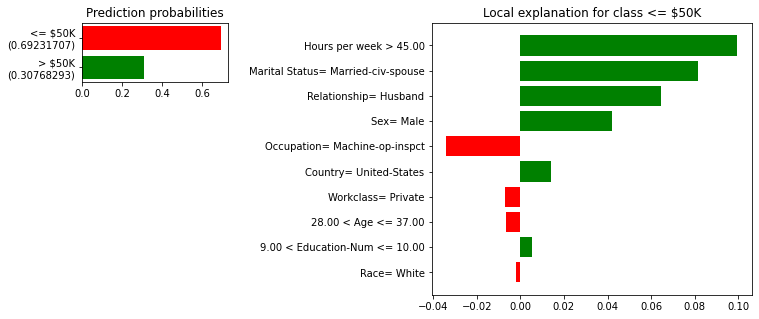

<Figure size 432x288 with 0 Axes>

In [15]:
plot_explanation(exp1, mapping)

***

**Task 4**: Please provide comments on the above explanation provided by LIME.

***

The LIME explanation shows which features had a positive effect on the prediction of income <= 50K. These are, in descending order, Hours per week, Marital Status, Relationship, Sex and Country.
The explanation also shows features which had a negative effect on the prediction, and pushed the prediction more towards income => 50K. These are, in descending order, Occupation, Age, Workclass, Race and Education-Num.

I find it interesting that the high number of Hours per week, being over 45, was a strong predictor of the income being <= 50K. Likewise other features, such as being male, married and living in the united states all would seem to my intuition to be factors leading to a predicted income over 50K.

***
**Task 5**: Please change the value of one or two features the change the prediction of the classifier:



In [16]:
instanceModified1 = X_test.iloc[i]
instanceModified1['Occupation'] = 11
instanceModified1['Education-Num'] = 13
print(instanceModified1)

Age               36.0
Workclass          4.0
Education-Num     13.0
Marital Status     2.0
Occupation        11.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    48.0
Country           39.0
Name: 31797, dtype: float32


Intercept -0.02563761674972534
Prediction_local [0.51097305]
Right: 0.74510103


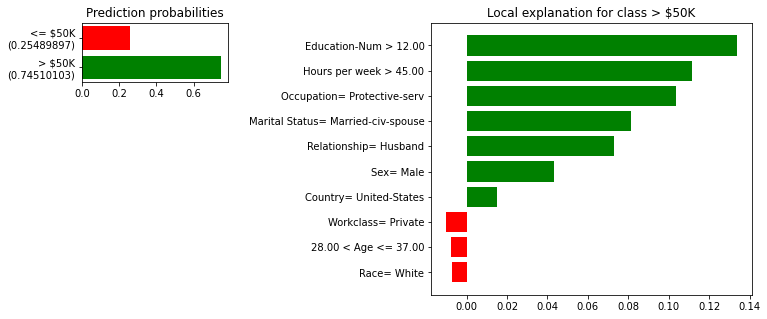

<Figure size 432x288 with 0 Axes>

In [17]:
expM1 = explainer.explain_instance(instanceModified1.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified1.values))
plot_explanation(expM1, mapping)

***
**Task 6**:  How did you choose these features for which you have changed the value? How did you chose these values?

My approach involved some trial and error, putting in different values and trying different features, and seeing what the new explanation said. I also used some intuition, such as believing that the occupation type and education level would push the prediction towards => 50K. I also referred back to the 'Feature Importances' above.

I also ensured that the person I chose to do this experiment on had initial prediction probabilities that weren't too extreme. This made it easier to find values which would swap the prediction.

## When a person's income > $50K


Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as higher $\$50$K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.
It is interesting to note that the prediction probabilities only has a prediction of this outcome as being 74.5, given the number and strength of the green bars.

***

**Task 7**: Please find a person for which the income is > $\$50$K and the prediction is correct.

***

In [18]:
# Change only the value of to select that person:
j = 12
###########

exp2 = explainer.explain_instance(X_test.iloc[j].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[j].values))
proba2 = xgc_np.predict_proba(X_test.values)[j]

print("********************")
print('Test id: ' , j)
print('Probability(',exp2.class_names[0],") =", exp2.predict_proba[0])
print('Probability(',exp2.class_names[1],") =", exp2.predict_proba[1])
print('Predicted Label:', predictions[j])
print('True class: ' , y_test[j])
print("********************")


Intercept 0.04296117850702057
Prediction_local [0.35343115]
Right: 0.71684
********************
Test id:  12
Probability( <= $50K ) = 0.28315997
Probability( > $50K ) = 0.71684
Predicted Label: 1
True class:  1
********************


The classifier got this example right (it predicted income $>\$50$K). Let's have a look at the explanation provided by LIME:


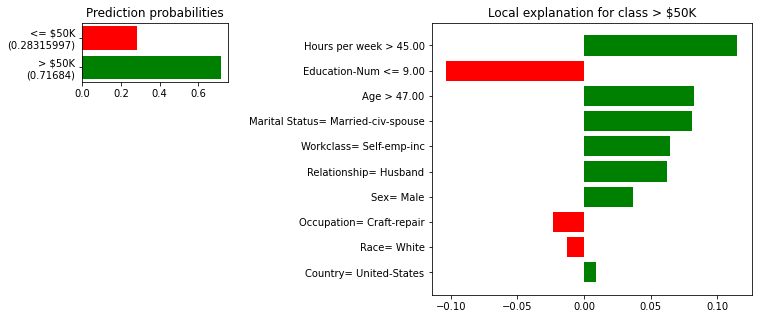

<Figure size 432x288 with 0 Axes>

In [19]:
plot_explanation(exp2, mapping)

***

**Task 8**: Please provide comments on the above explanation provided by LIME.

***

There are only two features pushing the prediction away from > 50K, these are the Education-Num and the Occupation. Education-Num is the most influential single feature, but the features that push towards > 50K overrule it. The probability of this prediction is only 71.7, which seems reasonable given the distribution of red and green bars in the explanation.

***
**Task 9**: Please change the value of one or two features the change the prediction of the classifier:



In [20]:
instanceModified2 = X_test.iloc[j]
instanceModified2['Country'] = 1
instanceModified2['Hours per week'] = 20
print(instanceModified2)

Age               48.0
Workclass          5.0
Education-Num      9.0
Marital Status     2.0
Occupation         3.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    20.0
Country            1.0
Name: 32462, dtype: float32


Intercept 0.16264555803771802
Prediction_local [0.30835246]
Right: 0.29884592


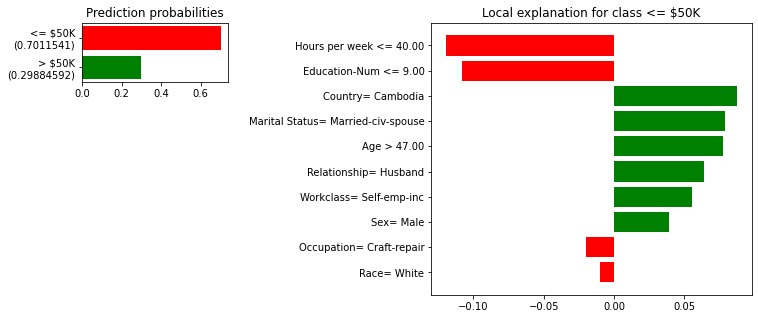

<Figure size 432x288 with 0 Axes>

In [21]:
expM2 = explainer.explain_instance(instanceModified2.values, xgc_np.predict_proba,
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified2.values))
plot_explanation(expM2, mapping)

***
**Task 10**:  How did you choose these features for which you have changed the value? How did you chose these values?

My approach again involved some trial and error, putting in different values and trying different features, and seeing what the new explanation said. 
I also used some intuition, such as believing that countries with lower GDP might also affect the prediction, and that someone who worked less hours would be paid less.

Again, I also ensured that the person I chose to do this experiment on had initial prediction probabilities that weren't too extreme. This made it easier to find values which would swap the prediction.

# When a person's income actual is different than predicted

Lime shows which features were the most influential in the model taking the incorrect decision of predicting the person's income. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 11**: Please find a person for which the the prediction is **incorrect**.

***

In [22]:
# Change only the value of to select that person:
k = 7
###########

exp3 = explainer.explain_instance(X_test.iloc[k].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[k].values))
proba3 = xgc_np.predict_proba(X_test.values)[k]

print("********************")
print('Test id: ' , k)
print('Probability(',exp3.class_names[0],") =", exp3.predict_proba[0])
print('Probability(',exp3.class_names[1],") =", exp3.predict_proba[1])
print('Predicted Label:', predictions[k])
print('True class: ' , y_test[k])
print("********************")


Intercept 0.0943196024829111
Prediction_local [0.22130026]
Right: 0.7511653
********************
Test id:  7
Probability( <= $50K ) = 0.24883473
Probability( > $50K ) = 0.7511653
Predicted Label: 1
True class:  0
********************


The classifier got this example classified incorrectly. Let's have a look at the explanation provided by LIME:


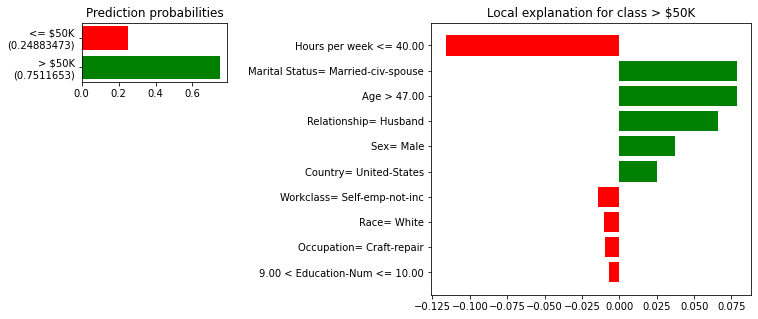

<Figure size 432x288 with 0 Axes>

In [23]:
plot_explanation(exp3, mapping)


***

**Task 12**: Please provide comments on the above explanation provided by LIME.

***

The most significant feature for this score appears to be Hours per week, which is the highest score, but is going against the overall prediction. The next 4 highly scored features all support the overall prediction, and in this case, have erroneously overruled the top scored feature.

***
**Task 13**: Please change the value of one or two features the change the prediction of the classifier (to get a correct prediction):



In [24]:
instanceModified3 = X_test.iloc[k]
instanceModified3['Hours per week'] = 47
instanceModified3['Occupation'] = 11
print(instanceModified3)

Age               51.0
Workclass          6.0
Education-Num     10.0
Marital Status     2.0
Occupation        11.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    47.0
Country           39.0
Name: 4048, dtype: float32


Intercept -0.024013461598319713
Prediction_local [0.41183895]
Right: 0.24021122


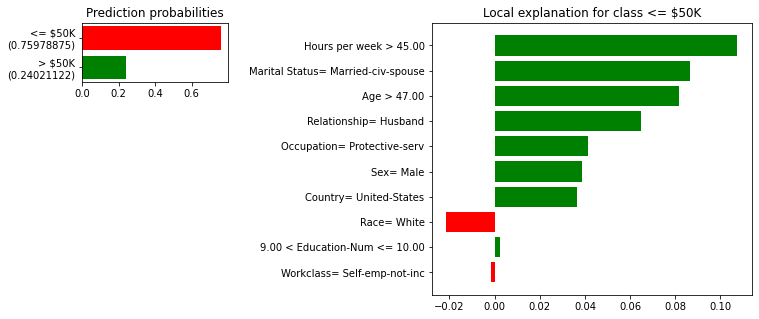

<Figure size 432x288 with 0 Axes>

In [25]:
expM3 = explainer.explain_instance(instanceModified3.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified3.values))
plot_explanation(expM3, mapping)

***
**Task 14**:  How did you choose these features for which you have changed the value? How did you chose these values?

***

My approach here again used some trial and error. There seemed to me to be a counter-intuitive effect where having high Hours per week actually led to a prediction of <= 50K. I suspect that this only works when combined with other values for other features, in this instance, I chose to accompany it with an Occupation of 'Protective-serv'. My intuition was that people who are in industries that pay low amounts per hour may have to work excessive hours.

As in the above tasks, I also ensured that the person I chose to do this experiment on had initial prediction probabilities that weren't too extreme. This made it easier to find values which would swap the prediction.

# Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.

Let's use the DecisionTreeClassifier provided by sklearn on our dataset:

In [26]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train.values, y_train)
tree.fit(X_train.values, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

In [27]:
predictions = tree.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


In [28]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7417
           1       0.75      0.40      0.52      2352

    accuracy                           0.82      9769
   macro avg       0.79      0.68      0.71      9769
weighted avg       0.81      0.82      0.80      9769



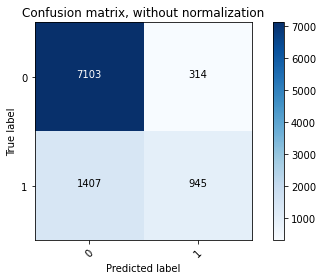

In [29]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')




***
**Task 15**:  Please provide comments on the performance of the decision Tree.
***

As discussed previously, interpreting a confusion matrix depends on the context and aims of the model.
In this confusion matrix, we can again see that the label 1 is causing problems, and again I am assuming that this is at least partly caused by imbalanced classes.

Comparing it to the previous confusion matrix, we see that the TP score has improved, as has the FN. However, the TN and FP have both become worse. This model is particularly poor at predicting label 1. There are 2352 instances of label 1 in the dataset, and this model incorrectly labelled 1407 of them as being label 0.

# Visualzing the Tree

Let's generate a GraphViz representation of the decision tree:



In [30]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=headers, 
                filled=True, rounded=True, impurity= False, class_names=['<=$50K','>$50K'])


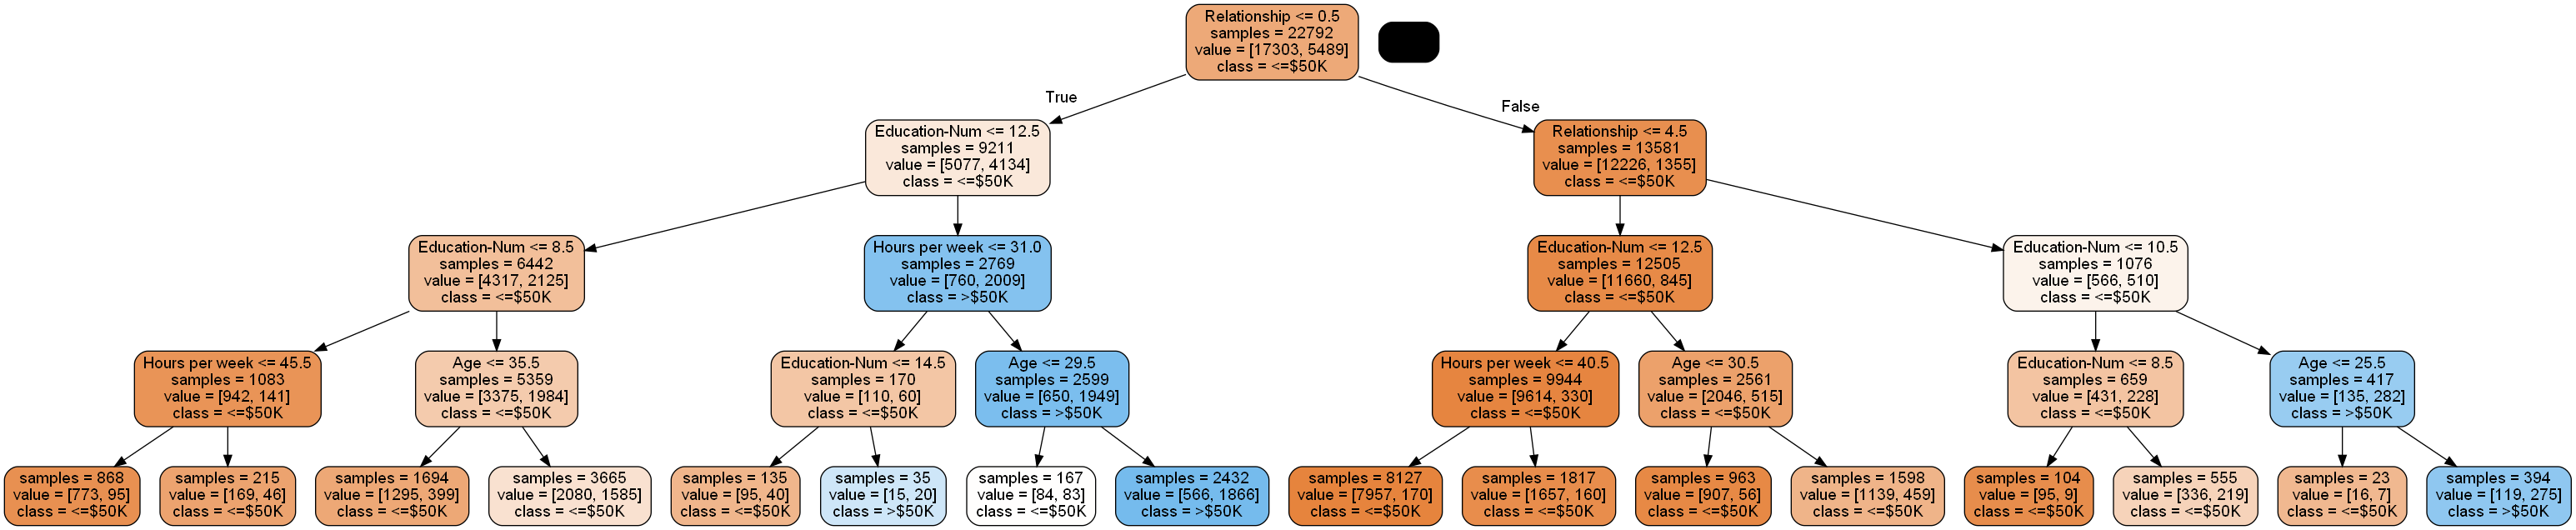

In [31]:
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

***
**Task 16**:  Explain the tree structure (including the meaning of the colors). 
***

In this tree the colours represent the classfication. The blues represent > 50K and the oranges represent <= 50K. The intensity or saturation of the colour represents the ratios seen in the 'values'. A higher ratio results in a more intense colour.

The top of the tree, where there is a single node, shows the first split made by the model - the one which results in the best performance. The cell shows a logical decision, testing whether the value of Relationship is <= 0.5. Each outcome (True or False) leads to a new cell where a new logical test is taken - again the test is based on what provides the greatest gain for the model.
The tree shows True results as branching to the left, and False results branching to the right. Each path along the tree leads to an end node (or leaf node) which provides a classification. Each path involves 4 logical tests (as per the max_depth=4 parameter).

The only features which appear in the splits of the tree are Relationship, Education-Num, Age and Hours per week.

Summing up the 'values' in the end nodes shows that the <= 50K classification is much more common than the > 50K classification.

# Explanation using LIME

Select any person from the dataset and get the LIME explanation for its classification.

In [32]:
# Change only the value of to select that person:
h = 7
###########

exp4 = explainer.explain_instance(X_test.iloc[h].values, tree.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[h].values))
proba1 = tree.predict_proba(X_test.values)[h]

print("********************")
print('Test id: ' , h)
print('Probability(',exp4.class_names[0],") =", exp4.predict_proba[0])
print('Probability(',exp4.class_names[1],") =", exp4.predict_proba[1])
print('Predicted Label:', predictions[h])
print('True class: ' , y_test[h])
print("********************")


Intercept 0.11467548030920677
Prediction_local [0.33295001]
Right: 0.4324693042291951
********************
Test id:  7
Probability( <= $50K ) = 0.567530695770805
Probability( > $50K ) = 0.4324693042291951
Predicted Label: 0
True class:  0
********************


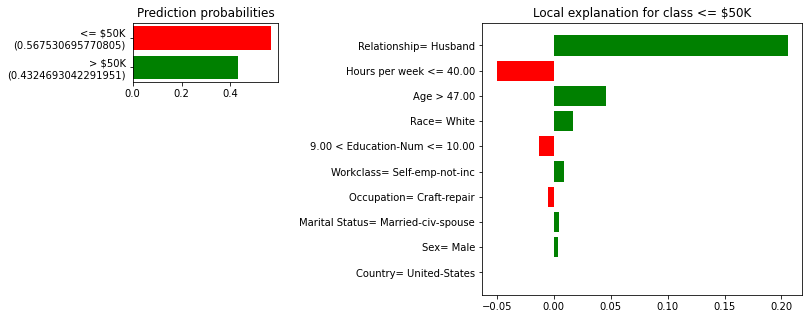

<Figure size 432x288 with 0 Axes>

In [33]:
plot_explanation(exp4, mapping)


***
**Task 17**:  Please provide comments on the above explanation provided by LIME using on the Tree structure above as a context to your explanation.
***

The LIME explanation shows the Relationship feature as being the most influential to the prediction. This makes sense when looking at the structure of the decision tree, which begins by using this feature.
The LIME explanation shows Hours per week as being the second most influential feature, although in a negative direction. Again, it is not surprising to see how important this feature is, given that it appears in several nodes of the decision tree. Likewise with the third highest scored feature in the LIME explanation, which is Age.

However, the fourth highest feature in the LIME explanation, Occupation, does not show up in the decision tree at all, yet the fifth feature, Education-Num, does.

I suspect that this is due to the way that LIME treats models as black boxes, and can only calculate statistical probabilities of the features that are important to a calcuation.

# Your own test example

**Task 18**: Following the tree above, create your own test example that will be classified as income > $\$50$K by the decision tree. Explain how you select the values for the features. Use LIME to provide explanation to that test example.

<hr>

I chose the values by eaxmining the visualisation of the tree, and finding an end node which had the result of income being over 50K. From that point, I traced the nodes back to the top of the tree and worked out what values of which features caused the splits.

I then traced that path from the top downwards, and selected the values for each variable that would take me to the end node I had chosen. The rest of the values I simply set to zero as they weren't used.

According to the LIME explanation, Education-Num and Relationship were the two strongest influences on the predicted outcome. These were also the two highest nodes in the tree. Once these two had been set to the values I chose, the vast majority of results lead to a prediction of > 50K.

Interestingly, the tree split a node based on whether the Hours per week was <= 31 (with the 'false' result leading to mostly > 50K predictions), but the explanation provided by LIME shows a negative influence as the hours were below 40.

Intercept 0.08213686932689163
Prediction_local [0.53180935]
Right: 0.7672697368421053


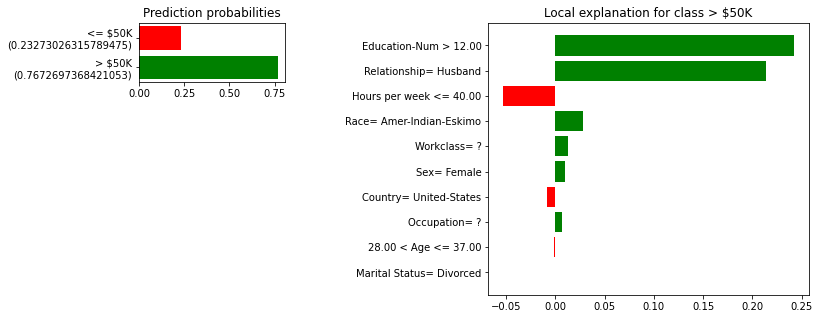

<Figure size 432x288 with 0 Axes>

In [34]:
test_example = ([30, 0, 13, 0, 0, 0, 0, 0, 32, 39])

exp4 = explainer.explain_instance(np.array(test_example), tree.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(np.array(test_example)))
plot_explanation(exp4, mapping)

# LIME for explaining prediction images

**Task 19**: Use the [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html) to build an image classifier, and then use the LIME framework with visualization to explain a few predicionts. You can use any classifier for this task (Neural network, Logistic regression, etc.).



Epoch 1/100
782/782 [==============================] - 11s 11ms/step - loss: 4.5948 - accuracy: 0.0123 - val_loss: 4.5305 - val_accuracy: 0.0206
Epoch 2/100
782/782 [==============================] - 8s 10ms/step - loss: 4.4651 - accuracy: 0.0263 - val_loss: 4.3316 - val_accuracy: 0.0431
Epoch 3/100
782/782 [==============================] - 8s 10ms/step - loss: 4.2723 - accuracy: 0.0484 - val_loss: 4.1170 - val_accuracy: 0.0821
Epoch 4/100
782/782 [==============================] - 8s 10ms/step - loss: 4.0849 - accuracy: 0.0765 - val_loss: 3.9260 - val_accuracy: 0.1128
Epoch 5/100
782/782 [==============================] - 8s 10ms/step - loss: 3.9226 - accuracy: 0.0989 - val_loss: 3.7299 - val_accuracy: 0.1416
Epoch 6/100
782/782 [==============================] - 8s 10ms/step - loss: 3.7808 - accuracy: 0.1214 - val_loss: 3.5818 - val_accuracy: 0.1737
Epoch 7/100
782/782 [==============================] - 8s 10ms/step - loss: 3.6563 - accuracy: 0.1397 - val_loss: 3.4757 - val_accuracy

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


(-0.5, 31.5, 31.5, -0.5)

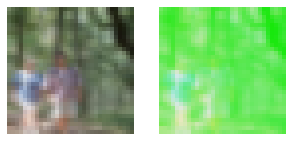

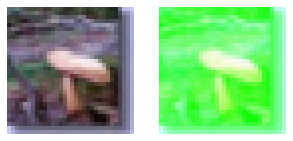

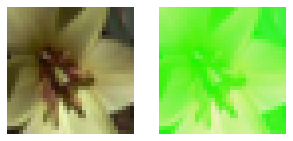

In [35]:
#Most of the following section of code was taken from:
#https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
#With only minor modifications made to allow it to work with my code.

import sys
from matplotlib import pyplot
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# load dataset
(trainX, trainY), (testX, testY) = cifar100.load_data()
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX = trainX/255
testX = testX/255

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='softmax'))

opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=1)

#Most of the following section of code was taken from:
#https://towardsdatascience.com/interpreting-image-classification-model-with-lime-1e7064a2f2e5
#With only minor modifications made to allow it to work with my code.

from skimage.segmentation import mark_boundaries
from lime import lime_image

explainer = lime_image.LimeImageExplainer(verbose=False)

explanation1 = explainer.explain_instance(testX[1].astype('double'), model.predict,  
                                         top_labels=1, hide_color=0, num_samples=100)

temp_1, mask_1 = explanation1.get_image_and_mask(explanation1.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation1.get_image_and_mask(explanation1.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

explanation2 = explainer.explain_instance(testX[3].astype('double'), model.predict,  
                                         top_labels=1, hide_color=0, num_samples=100)

temp_3, mask_3 = explanation2.get_image_and_mask(explanation2.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_4, mask_4 = explanation2.get_image_and_mask(explanation2.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

explanation3 = explainer.explain_instance(testX[5].astype('double'), model.predict,  
                                         top_labels=1, hide_color=0, num_samples=100)

temp_5, mask_5 = explanation3.get_image_and_mask(explanation3.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_6, mask_6 = explanation3.get_image_and_mask(explanation3.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(5,5))
ax3.imshow(mark_boundaries(temp_3, mask_3))
ax4.imshow(mark_boundaries(temp_4, mask_4))
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(5,5))
ax5.imshow(mark_boundaries(temp_5, mask_5))
ax6.imshow(mark_boundaries(temp_6, mask_6))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')
ax6.axis('off')


# Congratulations!

You've come to the end of this assignment, and have seen a lot of the ways to explain the predictions given by a classifier.

Congratulations on finishing this notebook! 

